In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime


import os

#from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost
import seaborn as sns


In [2]:
raw_df = pd.read_csv('rosbank_train.csv')

mcc_codes = pd.read_csv('mcc_codes.csv')
raw_df.head(5)
# target_sum - можно выкинуть, переменная участвует в другой задаче

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [3]:
mcc_codes.head()

,mcc,edited_description,combined_description,usda_description,irs_description,irs_reportable
0,742,Veterinary Services,Veterinary Services,Veterinary Services,Veterinary Services,Yes
1,763,Agricultural Co-operatives,Agricultural Co-operatives,Agricultural Co-operatives,Agricultural Cooperative,Yes
2,780,"Horticultural Services, Landscaping Services","Horticultural Services, Landscaping Services",Horticultural Services,Landscaping Services,Yes
3,1520,General Contractors-Residential and Commercial,General Contractors-Residential and Commercial,General Contractors-Residential and Commercial,General Contractors,Yes
4,1711,Air Conditioning Contractors – Sales and Insta...,Air Conditioning Contractors – Sales and Insta...,Air Conditioning Contractors – Sales and Insta...,"Heating, Plumbing, A/C",Yes


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [5]:
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [6]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

## Домашняя работа

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
4. **Обязательная часть**: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
5. **Дополнительная часть**: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. **Метрика оценки качества - ROC AUC**(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
6. Задания принимаются в виде ноутбука с кодов/картинками выполненной обязательной части + указанием места в leaderboard при решении дополнительной

При возникновении вопросов и для отправки домашнего задания - egsachko@gmail.com или http://fb.com/sachkoe
    

In [7]:
raw_df_grouped = raw_df[
    ['cl_id', 'amount', 'MCC']
].groupby(['cl_id', 'MCC']).agg(['sum', 'count'])

aggregated_dataset = raw_df_grouped.unstack('MCC').fillna(0)
#aggregated_dataset = raw_df_grouped.unstack('Cl')
aggregated_dataset.head()

amount                                              ...              \
         sum                                              ...  count        
MCC     742  763  780  1520 1711 1731 1750 1799 2741 2842 ...   8699 8911   
cl_id                                                     ...               
0        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.0   
1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.0   
5        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.0   
9        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.0   
10       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.0   

                                               
                                               
MCC   8931 8999 9211 9222 9311 9399 9402 9405  
cl_id                                          
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1      0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
5      0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  
9      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
10     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 688 columns]

# Клиент с максимальным количеством транзакций
# И типы операций по популярности

In [143]:
raw_df['cl_id'].value_counts().head(10)

2143    784
5373    512
5630    501
4564    499
1261    485
5398    483
10      463
5847    463
757     439
985     415
Name: cl_id, dtype: int64

In [144]:
raw_df['MCC'].value_counts().head(10)

5411    121640
6011     54382
5814     41351
5812     30027
5499     27237
5541     19816
5912     18728
5999     13073
6012     10056
5921      8578
Name: MCC, dtype: int64

In [145]:
raw_df['trx_category'].value_counts().head(10)

POS               416425
DEPOSIT            21216
WD_ATM_ROS         19104
WD_ATM_PARTNER      9948
C2C_IN              7306
WD_ATM_OTHER        7140
C2C_OUT             5456
BACK_TRX            2687
CAT                 1197
CASH_ADV              34
Name: trx_category, dtype: int64

##   Подготовка данных с помощью SQLlite

In [8]:
import sqlite3

In [9]:
conn = sqlite3.connect('transactions.db')

In [10]:
raw_df.to_sql('transactions_raw',if_exists = 'replace', con = conn)

In [11]:
 pd.io.sql.read_sql ("""select count(*), count(distinct cl_id) from transactions_raw limit 100""", conn)

,count(*),count(distinct cl_id)
0,490513,5000


In [12]:
 pd.io.sql.read_sql ("""select * from mcc_codes limit 10""", conn)

,index,mcc,edited_description,combined_description,usda_description,irs_description,irs_reportable
0,0,742,Veterinary Services,Veterinary Services,Veterinary Services,Veterinary Services,Yes
1,1,763,Agricultural Co-operatives,Agricultural Co-operatives,Agricultural Co-operatives,Agricultural Cooperative,Yes
2,2,780,"Horticultural Services, Landscaping Services","Horticultural Services, Landscaping Services",Horticultural Services,Landscaping Services,Yes
3,3,1520,General Contractors-Residential and Commercial,General Contractors-Residential and Commercial,General Contractors-Residential and Commercial,General Contractors,Yes
4,4,1711,Air Conditioning Contractors – Sales and Insta...,Air Conditioning Contractors – Sales and Insta...,Air Conditioning Contractors – Sales and Insta...,"Heating, Plumbing, A/C",Yes
5,5,1731,Electrical Contractors,Electrical Contractors,Electrical Contractors,Electrical Contractors,Yes
6,6,1740,"Insulation – Contractors, Masonry, Stonework C...","Insulation – Contractors, Masonry, Stonework C...",Insulation – Contractors,"Masonry, Stonework, and Plaster",Yes
7,7,1750,Carpentry Contractors,Carpentry Contractors,Carpentry Contractors,Carpentry Contractors,Yes
8,8,1761,"Roofing – Contractors, Sheet Metal Work – Cont...","Roofing – Contractors, Sheet Metal Work – Cont...",Roofing - Contractors,"Roofing/Siding, Sheet Metal",Yes
9,9,1771,Contractors – Concrete Work,Contractors – Concrete Work,Contractors – Concrete Work,Concrete Work Contractors,Yes


In [13]:
mcc_codes.to_sql('mcc_codes',if_exists = 'replace', con = conn)

In [14]:
#pd.io.sql.execute("""     drop table cl_channel """                   , conn)
pd.io.sql.execute("""
     
     drop table cl_channel 
     

    """
                   , conn)

In [15]:
#pd.io.sql.execute("""     drop table cl_channel """                   , conn)
pd.io.sql.execute("""
     
     create table cl_channel as
     select 
     distinct
     cl_id,
     channel_type
     --count(*)
     from transactions_raw
     where channel_type <> "NaN"
     --and cl_id = 50
    --group by 1,2

    """
                   , conn)

In [16]:
pd.io.sql.read_sql("""
     
select * from cl_channel limit 10

    """
                   , conn)

,cl_id,channel_type
0,50,type5
1,52,type5
2,54,type5
3,55,type5
4,56,type5
5,58,type5
6,59,type5
7,61,type5
8,63,type5
9,68,type5


In [17]:
datamart = pd.io.sql.read_sql("""
     select 
     t.PERIOD,
     CAST(substr(t.PERIOD,4,2) as decimal) PERIOD_MONTH,
     t.cl_id,
     t.MCC,
     ch.channel_type,
     t.currency,
     t.TRDATETIME,
     t.amount,
     t.trx_category,
     t.target_flag,
     t.target_sum,
     t.TRDATETIME,
     cast(strftime("%w",(substr(t.PERIOD,7,4)||"-"||substr(t.PERIOD,4,2)||"-"||substr(t.TRDATETIME,1,2))) as decimal) TR_week_day,
     cast(substr(t.TRDATETIME,6,2) as decimal) TR_hour,
     c.usda_description
     from transactions_raw as  t
     left  join mcc_codes as c
     on t.MCC = c.MCC
     left join cl_channel as ch
     on t.cl_id = ch.cl_id
    
     order by 1
    -- limit 100
    """
                   , conn)

In [18]:
datamart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 15 columns):
PERIOD              490513 non-null object
PERIOD_MONTH        490513 non-null int64
cl_id               490513 non-null int64
MCC                 490513 non-null int64
channel_type        487603 non-null object
currency            490513 non-null int64
TRDATETIME          490513 non-null object
amount              490513 non-null float64
trx_category        490513 non-null object
target_flag         490513 non-null int64
target_sum          490513 non-null float64
TRDATETIME          490513 non-null object
TR_week_day         490513 non-null int64
TR_hour             490513 non-null int64
usda_description    488946 non-null object
dtypes: float64(2), int64(7), object(6)
memory usage: 56.1+ MB


In [19]:
datamart.head(5)

,PERIOD,PERIOD_MONTH,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,TRDATETIME,TR_week_day,TR_hour,usda_description
0,01/01/2017,1,21,5533,None,810,20JAN17:00:00:00,50.00,POS,0,0.0,20JAN17:00:00:00,5,17,"Automotive Parts, Accessories Stores"
1,01/01/2017,1,21,6011,None,810,13JAN17:20:03:04,20000.00,DEPOSIT,0,0.0,13JAN17:20:03:04,5,17,Financial Institutions – Manual Cash Disbursem...
2,01/01/2017,1,21,5411,None,810,24JAN17:00:00:00,741.83,POS,0,0.0,24JAN17:00:00:00,2,17,Grocery Stores
3,01/01/2017,1,21,5533,None,810,22JAN17:00:00:00,100.00,POS,0,0.0,22JAN17:00:00:00,0,17,"Automotive Parts, Accessories Stores"
4,01/01/2017,1,21,5411,None,810,25JAN17:00:00:00,586.00,POS,0,0.0,25JAN17:00:00:00,3,17,Grocery Stores


# Функции для трансформации категориальных переменных

In [20]:
def get_one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [21]:
def get_woe_v1(df_train, df_test, col, target_col):
    all_good = len(df_train[df_train[target_col] == 1][col])
    all_bad = len(df_train[df_train[target_col] == 0][col])
    odds_series = (
        df_train[df_train[target_col] == 1][col].value_counts()
        /
        df_train[df_train[target_col] == 0][col].value_counts()
    )
    odds_series = odds_series / all_good * all_bad
    category_woe_dict = np.log(odds_series).to_dict()
    df_train[col + '_woe'] = df_train[col].apply(category_woe_dict.get)
    df_test[col + '_woe'] = df_test[col].apply(category_woe_dict.get)
    return df_train, df_test

In [22]:
from sklearn.model_selection import train_test_split


In [23]:
y = datamart['target_sum'].copy()

# Формирование выборки тренировочной и тестовой,
# Для отладки использую сэмпл т.к. долго считается.

In [24]:
datamart_s = datamart.sample(1000)

In [25]:
datamart_s = datamart.fillna(0)

In [26]:
datamart_train, datamart_test, y_train, y_test = train_test_split(datamart_s, y, test_size=0.3, random_state=42)

In [44]:
    columns_to_get_counts = [
    'PERIOD_MONTH',
 #   'cl_id',
    'MCC',
    'channel_type',
    'currency',
    'trx_category',
    'TR_week_day',
    'TR_hour'
    ]

In [45]:
    data = get_one_hot(
        datamart_train,
        ['cl_id']
    )

In [46]:
    data = get_one_hot(
        datamart_test,
        ['cl_id']
    )

# Нормализация и формирование WOE переменных

In [27]:
datamart_train['target_sum_norm'] = (datamart_train['target_sum']-datamart_train['target_sum'].min())/(datamart_train['target_sum'].max()-datamart_train['target_sum'].min())
datamart_test['target_sum_norm'] = (datamart_test['target_sum']-datamart_test['target_sum'].min())/(datamart_test['target_sum'].max()-datamart_test['target_sum'].min())

C:\Users\rajah\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [36]:
datamart_train['amount_norm'] = (datamart_train['amount']-datamart_train['amount'].min())/(datamart_train['amount'].max()-datamart_train['amount'].min())
datamart_test['amount_norm'] = (datamart_test['amount']-datamart_test['amount'].min())/(datamart_test['amount'].max()-datamart_test['amount'].min())

C:\Users\rajah\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
    for col_get_prob in columns_to_get_counts:
        datamart_train, datamart_test = get_woe_v1(datamart_train, datamart_test, col_get_prob, "target_sum_norm" )

In [37]:
datamart_train = datamart_train.fillna(0)
datamart_test = datamart_train.fillna(0)

In [38]:
datamart_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343359 entries, 392982 to 121958
Data columns (total 17 columns):
PERIOD              343359 non-null object
PERIOD_MONTH        343359 non-null int64
cl_id               343359 non-null int64
MCC                 343359 non-null int64
channel_type        343359 non-null object
currency            343359 non-null int64
TRDATETIME          343359 non-null object
amount              343359 non-null float64
trx_category        343359 non-null object
target_flag         343359 non-null int64
target_sum          343359 non-null float64
TRDATETIME          343359 non-null object
TR_week_day         343359 non-null int64
TR_hour             343359 non-null int64
usda_description    343359 non-null object
target_sum_norm     343359 non-null float64
amount_norm         343359 non-null float64
dtypes: float64(4), int64(7), object(6)
memory usage: 47.2+ MB


In [49]:
datamart_train.head()

,PERIOD,PERIOD_MONTH,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,...,usda_description,target_sum_norm,amount_norm,PERIOD_MONTH_woe,MCC_woe,channel_type_woe,currency_woe,trx_category_woe,TR_week_day_woe,TR_hour_woe
392982,01/09/2017,9,5812,5411,type1,810,16SEP17:00:00:00,2770.64,POS,1,...,Grocery Stores,0.005761,0.000197,NaN,-1.048473,NaN,0.015402,0.100962,0.607656,0.240388
406168,01/10/2017,10,2040,5814,type2,810,17OCT17:00:00:00,931.28,POS,1,...,Fast Food Restaurants,0.002740,0.000066,NaN,-1.334935,2.15389,0.015402,0.100962,-0.717365,0.240388
144367,01/04/2017,4,3822,5411,type1,810,25APR17:00:00:00,362.00,POS,1,...,Grocery Stores,0.003545,0.000026,1.208242,-1.048473,NaN,0.015402,0.100962,-0.717365,0.240388
432083,01/11/2016,11,9667,5814,type1,810,01NOV16:00:00:00,617.00,POS,0,...,Fast Food Restaurants,0.000000,0.000044,NaN,-1.334935,NaN,0.015402,0.100962,-0.717365,NaN
306406,01/07/2017,7,4984,5812,type1,810,06JUL17:00:00:00,231.00,POS,1,...,Eating places and Restaurants,0.000435,0.000016,NaN,-0.133049,NaN,0.015402,0.100962,-0.751913,0.240388


In [60]:
datamart_train = datamart_train.fillna(0)
datamart_test = datamart_train.fillna(0)

In [50]:
train_columns = [
    col for col in datamart_train.columns.tolist()
    if col not in set(
        [
'PERIOD',
            'PERIOD_MONTH',
 'cl_id',
 'MCC',
             'TR_week_day',
            'amount',
 'channel_type',
 'currency',
 'TRDATETIME', 
 'trx_category',
 'target_flag',
 'usda_description',
  'channel_type_woe',
 'target_sum',
            
 'TR_hour',
            'currency_woe'
        ]
    )
]

In [51]:
train_columns

['target_sum_norm',
 'amount_norm',
 'PERIOD_MONTH_woe',
 'MCC_woe',
 'trx_category_woe',
 'TR_week_day_woe',
 'TR_hour_woe']

# Зависимость переменных

In [52]:
corr = datamart_train[train_columns].corr()
corr

,target_sum_norm,amount_norm,PERIOD_MONTH_woe,MCC_woe,trx_category_woe,TR_week_day_woe,TR_hour_woe
target_sum_norm,1.000000e+00,-1.700674e-03,4.734199e-03,1.931503e-02,8.979739e-03,3.569380e-03,-1.137904e-14
amount_norm,-1.700674e-03,1.000000e+00,9.299826e-03,-5.052954e-02,2.320289e-02,-8.651842e-03,4.357817e-15
PERIOD_MONTH_woe,4.734199e-03,9.299826e-03,1.000000e+00,2.049910e-03,-2.274003e-03,2.304166e-02,-4.373731e-12
MCC_woe,1.931503e-02,-5.052954e-02,2.049910e-03,1.000000e+00,-7.011401e-02,1.798561e-02,8.208545e-15
trx_category_woe,8.979739e-03,2.320289e-02,-2.274003e-03,-7.011401e-02,1.000000e+00,-4.847316e-03,1.164892e-12
TR_week_day_woe,3.569380e-03,-8.651842e-03,2.304166e-02,1.798561e-02,-4.847316e-03,1.000000e+00,-2.053230e-13
TR_hour_woe,-1.137904e-14,4.357817e-15,-4.373731e-12,8.208545e-15,1.164892e-12,-2.053230e-13,1.000000e+00


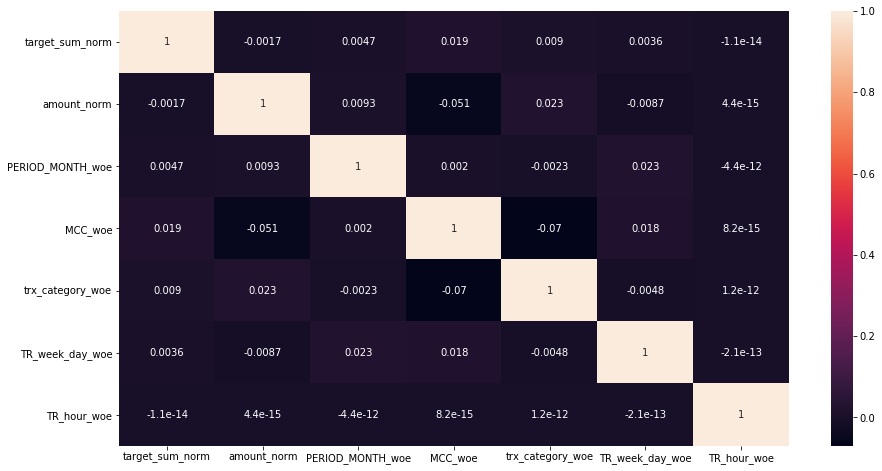

In [53]:
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [132]:
train_columns = [
    col for col in datamart_train.columns.tolist()
    if col not in set(
        [
'PERIOD',
   'PERIOD_MONTH',
 'cl_id',
 'MCC',
 'channel_type',
 'currency',
 'TRDATETIME', 
 'trx_category',
 'target_flag',
 'usda_description',
  'channel_type_woe',
 'target_sum',
 'TR_hour_woe',
            'currency_woe',
             'TR_hour',
            'amount'
        ]
    )
]

In [133]:
train_columns

['TR_week_day',
 'target_sum_norm',
 'amount_norm',
 'PERIOD_MONTH_woe',
 'MCC_woe',
 'trx_category_woe',
 'TR_week_day_woe']

In [56]:
x_train = datamart_train[train_columns]
y_train = datamart_train['target_sum']
x_test = datamart_test[train_columns]
y_test = datamart_test['target_sum']

# Тут я попытался использовать XBOOST, но очень долго считается, я думаю не сходится алгоритм, но опыта пока недостаточно понять в чем дело.

In [ ]:
import xgboost
xgb = xgboost.XGBClassifier(max_depth=3)#, n_jobs=-1)
xgb.fit(x_train, y_train)
y_train_predict = xgb.predict_proba(x_train)[:, 1]
y_test_predict = xgb.predict_proba(x_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

In [ ]:
Dep_left_count_df = datamat.groupby(['cl_id','TR_week_day'])[['MCC_woe']].count(). # 
Dep_count_df = data.groupby(['sales','salary'])[['salary']].count()
Dep_avg_sat_df = data.groupby(['sales','salary'])['satisfaction_level'].agg(['mean'])
Dep_df = Dep_left_count_df.join(Dep_count_df)
Dep_df = Dep_df.join(Dep_avg_sat_df)
Dep_df

In [78]:
# Common imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10, 5)

# Регрессии


In [82]:
est = smf.ols('target_sum ~ amount_norm+PERIOD_MONTH_woe+MCC_woe+trx_category_woe+TR_week_day_woe+TR_hour_woe', datamart_train).fit()
est_res = est.summary()
est_res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.456e+05,6348.816,38.688,0.000,2.33e+05,2.58e+05
amount_norm,-6.483e+05,8.14e+05,-0.797,0.426,-2.24e+06,9.47e+05
PERIOD_MONTH_woe,2.663e+04,5284.330,5.040,0.000,1.63e+04,3.7e+04
MCC_woe,3.02e+04,2690.851,11.223,0.000,2.49e+04,3.55e+04
trx_category_woe,6.019e+04,8755.846,6.874,0.000,4.3e+04,7.74e+04
TR_week_day_woe,8219.8967,5081.835,1.618,0.106,-1740.352,1.82e+04
TR_hour_woe,-4.494e+05,2.94e+04,-15.262,0.000,-5.07e+05,-3.92e+05


In [83]:
three_x_lm = smf.ols('target_sum_norm ~ amount_norm+PERIOD_MONTH_woe+MCC_woe+trx_category_woe+TR_week_day_woe+TR_hour_woe', datamart_train).fit()
rss = np.sum(three_x_lm.resid ** 2)
print("RSS:", rss)
print("RSE:", np.sqrt(rss / (datamart_train.shape[0] - 3 - 1)))
print("R^2:", three_x_lm.rsquared)

RSS: 339.816572565059
RSE: 0.03145941116770619
R^2: 0.00116663884056456


In [63]:
from sklearn.linear_model import Ridge, Lasso

In [71]:
X = datamart_train[train_columns].as_matrix()
y = datamart_train.target_sum_norm

C:\Users\rajah\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [108]:
rg = Lasso(alpha=1000, normalize=True, max_iter=1e5).fit(X, y)
print(rg.intercept_)
print(rg.coef_)

0.003494203806005189
[-0.  0.  0. -0.  0.  0.  0.  0.]


In [109]:
rg2 = Ridge(alpha=1000, normalize=True, max_iter=1e5).fit(X, y)
print(rg.intercept_)
print(rg.coef_)

0.003494203806005189
[-0.  0.  0. -0.  0.  0.  0.  0.]


In [123]:
from sklearn.linear_model import Lasso

def lasso_regression(data, predictors, alpha, models_to_plot={}):
    # fit
    lassoreg = Lasso(alpha=alpha, normalize=True, max_iter=1e5)
    lassoreg.fit(data[predictors], data['target_sum'])
    y_pred = lassoreg.predict(data[predictors])
    
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['target_sum'], y_pred)
        plt.plot(data['target_sum'], data['target_sum'], '.')
        plt.title('Plot for alpha: %.3g' % alpha)
    
    # format
    rss = sum((y_pred-data['target_sum']) ** 2)
    ret = [rss]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

In [124]:
predictors = []

In [134]:
train_columns

['TR_week_day',
 'target_sum_norm',
 'amount_norm',
 'PERIOD_MONTH_woe',
 'MCC_woe',
 'trx_category_woe',
 'TR_week_day_woe']

In [135]:
predictors = train_columns
lasso_regression(datamart_train, predictors, alpha_lasso[i], models_to_plot)

[498773674.74623114,
 -73.8881523590826,
 22.042664996197804,
 46065785.265132986,
 -278.8950909924198,
 0.6685199229366013,
 1.602483014332573,
 1.0948722502821986,
 -44.301862924925416]

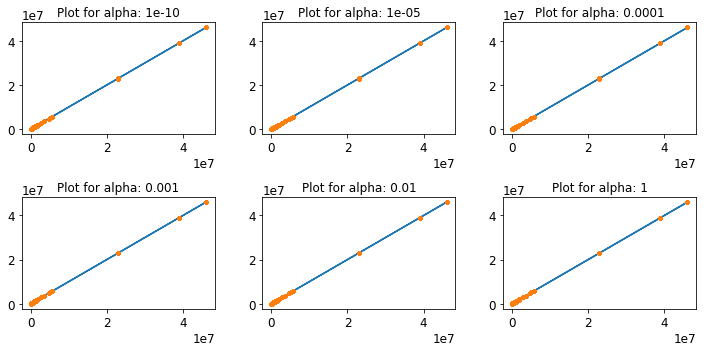

In [138]:
predictors = train_columns
#predictors.extend(['x_%d' % i for i in range(2, 16)])

# alphas
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

# create dataframe to store coefficients
col = ['rss', 'intercept'] + ['coef_%d' % i for i in range(1, 8)]
ind = ['alpha_%.2g' % alpha_lasso[i] for i in range(0, 10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)


models_to_plot = {1e-10: 231, 1e-5: 232, 1e-4: 233, 1e-3: 234, 1e-2: 235, 1: 236}

#Iterate over the 10 alpha values:
for i in range(10):
    coef_matrix_lasso.iloc[i, ] = lasso_regression(datamart_train, predictors, alpha_lasso[i], models_to_plot)
plt.show()

# Предсказательные силы моделей никакие как я понимаю. Буду учиться дальше)